# Loka Challenge

In [1]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
from pathlib import Path
import itertools
from utils import Colors, TimeUnit
from utils import post_process_data, draw_histogram, display_columns, display_color_channels
from preprocessing import butter_lowpass_filter, moving_average
from ppg import (power_spectrum, ppg_by_ica_sources, ppg_by_grd, 
                 ppg_by_green_signal, select_ppg)
from ppg import PPG
from sklearn.decomposition import FastICA


### Introduction

- Goal: **Estimate the heart rate** of an individual given a _photoplethysmogram_ (PPG);


- What is a _photoplethysmogram_?

Simple and low cost optical technique that can be used to detect blood volume changes in the microvascular bed of tissue. 

PPG is a technology which determines blood volume pulse variation by measuring the **amount of reflected light** in the build in camera of smart devices. PPG senses teh temporal variation of light transmitted by and reflected from the human body due to the change in volume of blood vessels under the skin and oxygenation levels of the blood that occurs during respiration. The focus is on extracting the cardiac heart rate of the subject by analysing the color video signal and identifying periodic components. 

### Data Analysis

The dataset provided consists of several folders, where each folder represents an experiment, that contain two .csv files each. 

In [2]:
df_ppg = pd.read_csv("../data/P1LC4/P1LC4_ppg.csv")
df_raw = pd.read_csv("../data/P1LC4/P1LC4.csv")

In [3]:
df_ppg.shape

(5543, 4)

In [4]:
df_ppg.head()

B          G          R    Time[ms]
0  95.971738  87.042885  65.695708    0.000000
1  96.208885  87.062527  65.954960   33.333333
2  95.883603  86.823954  65.622120   66.666667
3  96.044902  86.944108  65.708531  100.000000
4  96.378825  87.039991  66.098793  133.333333

In [4]:
df_ppg.describe()

B            G            R       Time[ms]
count  5543.000000  5543.000000  5543.000000    5543.000000
mean    121.113872   100.073294    72.309779   92366.666667
std       0.563410     0.804035     0.589635   53342.353404
min     119.470648    98.185787    70.540676       0.000000
25%     120.676396    99.498696    71.843740   46183.333333
50%     121.145520    99.931182    72.233456   92366.666667
75%     121.523417   100.469823    72.809006  138550.000000
max     123.071585   102.287532    74.132299  184733.333333

In [5]:
#Normalize the data
df_ppg = post_process_data(df_ppg)

In [5]:
df_ppg.shape

(5543, 5)

In [6]:
df_ppg.head()

B         G         R     Time_ms    Time_s
0  2.001988  2.287527  1.337841    0.000000  0.000000
1  2.619388  2.092184  2.014784   33.333333  0.033333
2  2.667611  2.081563  2.101183   66.666667  0.066667
3  2.105695  2.066817  1.590124  100.000000  0.100000
4  2.289754  2.001144  1.904492  133.333333  0.133333

In [7]:
df_ppg.describe()

B             G             R        Time_ms       Time_s
count  5.543000e+03  5.543000e+03  5.543000e+03    5543.000000  5543.000000
mean  -1.542351e-14  2.871398e-16  4.101997e-15   92366.666667    92.366667
std    1.000090e+00  1.000090e+00  1.000090e+00   53342.353404    53.342353
min   -2.916833e+00 -2.347755e+00 -3.000604e+00       0.000000     0.000000
25%   -7.765497e-01 -7.147077e-01 -7.904569e-01   46183.333333    46.183333
50%    5.617772e-02 -1.767643e-01 -1.294531e-01   92366.666667    92.366667
75%    7.269706e-01  4.932182e-01  8.467468e-01  138550.000000   138.550000
max    3.475073e+00  2.754157e+00  3.091205e+00  184733.333333   184.733333

In [9]:
df_raw.head()

Time[ms]   HR[bpm]
0       833  77.77778
1       867  77.77778
2       900  71.64179
3       933  71.64179
4       967  71.64179

In [37]:
df_raw.describe()

Time[ms]      HR[bpm]
count    5516.000000  5516.000000
mean    92749.987491    63.569991
std     53082.524989    11.185544
min       833.000000    40.449440
25%     46791.750000    54.216870
50%     92750.000000    62.686570
75%    138708.250000    70.391060
max    184666.000000    91.525420

In [10]:
df_raw.shape

(5516, 2)

In [11]:
df_ppg.head()


B         G         R     Time_ms    Time_s
0 -0.536099  0.722195 -1.355842    0.000000  0.000000
1  0.000510  0.760586 -0.685979   33.333333  0.033333
2 -0.735530  0.294277 -1.545983   66.666667  0.066667
3 -0.370546  0.529126 -1.322711  100.000000  0.100000
4  0.385047  0.716539 -0.314337  133.333333  0.133333

In [8]:
display_color_channels(
    df=df_ppg,
    colors=[Colors.BLUE, Colors.GREEN, Colors.RED],
    time_range=(0, 60)
)

### Signal Preprocessing

In [14]:
df_ppg.head()

B         G         R     Time_ms    Time_s
0 -0.536099  0.722195 -1.355842    0.000000  0.000000
1  0.000510  0.760586 -0.685979   33.333333  0.033333
2 -0.735530  0.294277 -1.545983   66.666667  0.066667
3 -0.370546  0.529126 -1.322711  100.000000  0.100000
4  0.385047  0.716539 -0.314337  133.333333  0.133333

The time interval between two consecutive points is 1/30 seconds, which implies a frequency of 30Hz.

- To preserve relevant information, frequency components in human heart
rate bandwidth (40–240 beats per minute (BPM), which corresponds to 0.65–4 Hz) should not be surpressed

- Low Pass Filtering: suppresses frequency components outside the heart rate bandwidth

- Moving Average: smooths the signal and suppreses high-frequency noise. Choose M < 12 to avoid filtering heart pulse data.

In [9]:
#Sample Frequency
fs = 30.0
order = 5
cutoff = 4
#Number of points to use in the mooving average
filter = [False, True]
n_points = [None, 3, 6, 9, 12]

for f in filter:
    for m in n_points:
        if f:
            print('Using Low Pass Filter')
            for color in ['B', 'G', 'R']:
                df_ppg[f'{color}_F'] = butter_lowpass_filter(signal=df_ppg[color].values, 
                                                             cutoff=cutoff, 
                                                             fs=fs, 
                                                             order=order)
        else:
            print('NO Low Pass Filter')
            for color in ['B', 'G', 'R']:
                df_ppg[f'{color}_F'] = df_ppg[color].values
        
        if m:
            print(f'Moving Average with {m} points')
            for color in ['B', 'G', 'R']:
                df_ppg[f'{color}_F'] = moving_average(signal=df_ppg[f'{color}_F'], n_points=m)
        else:
            print('No Moving Average')
        
        #Display the preprocessed signals
        fig = display_color_channels(
                    df=df_ppg,
                    colors=[Colors.BLUE_F, Colors.GREEN_F, Colors.RED_F],
                    time_range=(0, 60)
                    )
        fig.show()
          


NO Low Pass Filter
No Moving Average


NO Low Pass Filter
Moving Average with 3 points


NO Low Pass Filter
Moving Average with 6 points


NO Low Pass Filter
Moving Average with 9 points


NO Low Pass Filter
Moving Average with 12 points


Using Low Pass Filter
No Moving Average


Using Low Pass Filter
Moving Average with 3 points


Using Low Pass Filter
Moving Average with 6 points


Using Low Pass Filter
Moving Average with 9 points


Using Low Pass Filter
Moving Average with 12 points


### Extracting PPG from color signals

**Consider PPG to be simply the green signal**

In [10]:
df_ppg = ppg_by_green_signal(df_ppg)

In [11]:
df_ppg.head()

B         G         R     Time_ms    Time_s       B_F       G_F  \
0  2.001988  2.287527  1.337841    0.000000  0.000000  1.557701  1.450415   
1  2.619388  2.092184  2.014784   33.333333  0.033333  1.706863  1.613131   
2  2.667611  2.081563  2.101183   66.666667  0.066667  1.848017  1.774720   
3  2.105695  2.066817  1.590124  100.000000  0.100000  1.965930  1.919052   
4  2.289754  2.001144  1.904492  133.333333  0.133333  2.039535  2.024396   

        R_F  Green_Source  
0  1.223815      1.450415  
1  1.354363      1.613131  
2  1.486020      1.774720  
3  1.611011      1.919052  
4  1.713224      2.024396

**Consider PPG to simply be the difference between the green and red channels**

In [12]:
df_ppg = ppg_by_grd(df_ppg)

In [13]:
df_ppg.head()

B         G         R     Time_ms    Time_s       B_F       G_F  \
0  2.001988  2.287527  1.337841    0.000000  0.000000  1.557701  1.450415   
1  2.619388  2.092184  2.014784   33.333333  0.033333  1.706863  1.613131   
2  2.667611  2.081563  2.101183   66.666667  0.066667  1.848017  1.774720   
3  2.105695  2.066817  1.590124  100.000000  0.100000  1.965930  1.919052   
4  2.289754  2.001144  1.904492  133.333333  0.133333  2.039535  2.024396   

        R_F  Green_Source  GRD_Source  
0  1.223815      1.450415    0.226600  
1  1.354363      1.613131    0.258768  
2  1.486020      1.774720    0.288699  
3  1.611011      1.919052    0.308041  
4  1.713224      2.024396    0.311172

In [14]:
display_columns(
    df=df_ppg,
    columns=['GRD_Source', 'Green_Source'],
    time_range=(0,60)
)

**Apply ICA (Independent Component Analysis)**

Linear mixing of signals from the three colour RGB channels can enhance the periodic HR component contained in the video signal. From that perpective, ICA appeared to be a useful algorithm capable of generating suitable mixing weights. 

There is an unfortunate contradiction in that signals are to be characterized due to being periodic but their timeline is not considered by these ICA algorithms. Unfortunaly, existing useful statistical algorithms either require prior knowledge of the period itself or analyse a single temporal signal. 

ICA is a type of blind source separation (BSS) in the sense that it computes a linear sum _W_ of available datasets _y_ (RGB colour channels in our case) with such weights _w_ as to maximize one independent source at a time.

- My the central limit theorem, the mixing signals must follow a gaussian distribution. Let's check on that:

In [18]:
draw_histogram(df_ppg, [Colors.BLUE, Colors.BLUE_F])

In [19]:
draw_histogram(df_ppg, [Colors.GREEN, Colors.GREEN_F])

In [21]:
draw_histogram(df_ppg, [Colors.RED, Colors.RED_F])

- The histograms of the three channels time series are kinda gaussian, which is an indicator that we can assume that the signals are a linear combination of source signals.

In an ideal case, where the number of mixed data sets y is the same as the number of perfectly statistically independent source components x, it gives full unmixing of such sources. The data sources x must not have a Gaussian distribution and there may only be linear mixes _A_ of these unknown sources.

The mixed datasets have the form _y(t)_ = _A_._x(t)_

the original independent components are found from _x(t)_ = _W_._y(t)_

_W_ is the unmixing matrix found by the ICA

In [24]:
channels = ['B', 'G', 'R']
for comb in itertools.combinations(channels, 2):
    fig = go.Figure()
    fig.add_trace(
            go.Scatter(
                x=df_ppg[comb[0]],
                y=df_ppg[comb[1]],
                name=f'{comb[0] and comb[1]}',
                mode='markers'
                )
        )
    fig.show()

        

- The three channels have a high correlation.

The position (index) of the desired output in the output matrix of the ICA varies due to the iterative character of the algorithm. Therefore, selection of the most relevant output component is required.

In [15]:
df_ppg = ppg_by_ica_sources(df=df_ppg)



c:\Users\F004959\.conda\envs\ppg\lib\site-packages\sklearn\decomposition\_fastica.py:488: FutureWarning:

From version 1.3 whiten='unit-variance' will be used by default.



Mixing Matrix
[[ 50.6230584   23.09274989 -44.39919306]
 [ 64.18808984  34.48139072  -6.56767904]
 [ 72.13075875  -4.68013549  -8.97485386]]
Max Peak Source:  1


In [16]:
df_ppg.head()

B         G         R     Time_ms    Time_s       B_F       G_F  \
0  2.001988  2.287527  1.337841    0.000000  0.000000  1.557701  1.450415   
1  2.619388  2.092184  2.014784   33.333333  0.033333  1.706863  1.613131   
2  2.667611  2.081563  2.101183   66.666667  0.066667  1.848017  1.774720   
3  2.105695  2.066817  1.590124  100.000000  0.100000  1.965930  1.919052   
4  2.289754  2.001144  1.904492  133.333333  0.133333  2.039535  2.024396   

        R_F  Green_Source  GRD_Source  ICA_Source_0  ICA_Source_1  \
0  1.223815      1.450415    0.226600      0.016185      0.009778   
1  1.354363      1.613131    0.258768      0.017992      0.011006   
2  1.486020      1.774720    0.288699      0.019834      0.012173   
3  1.611011      1.919052    0.308041      0.021599      0.013037   
4  1.713224      2.024396    0.311172      0.023065      0.013402   

   ICA_Source_2  ICA_Best_Source  
0     -0.011568         0.009778  
1     -0.012228         0.011006  
2     -0.012700         0.012173  
3     -0.012894         0.013037  
4     -0.012691         0.013402

In [24]:
df_ppg.shape

(5543, 13)

<AxesSubplot:>

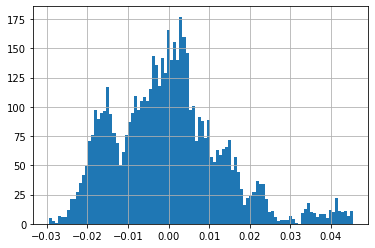

In [13]:
df_ppg['ICA_Source_0'].hist(bins=100)

<AxesSubplot:>

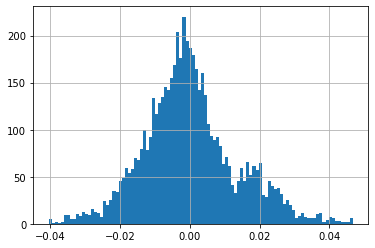

In [14]:
df_ppg['ICA_Source_1'].hist(bins=100)

<AxesSubplot:>

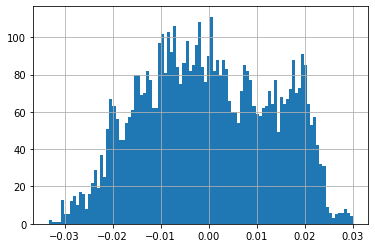

In [32]:
df_ppg['ICA_Source_2'].hist(bins=100)

In [15]:
df_ppg.to_csv('df_ppg.csv')

In [2]:
df_ppg = pd.read_csv('df_ppg.csv')

In [17]:
display_columns(
    df_ppg, 
    ['ICA_Source_0', 'ICA_Source_1', 'ICA_Source_2'],
    time_range=(0,60)
)

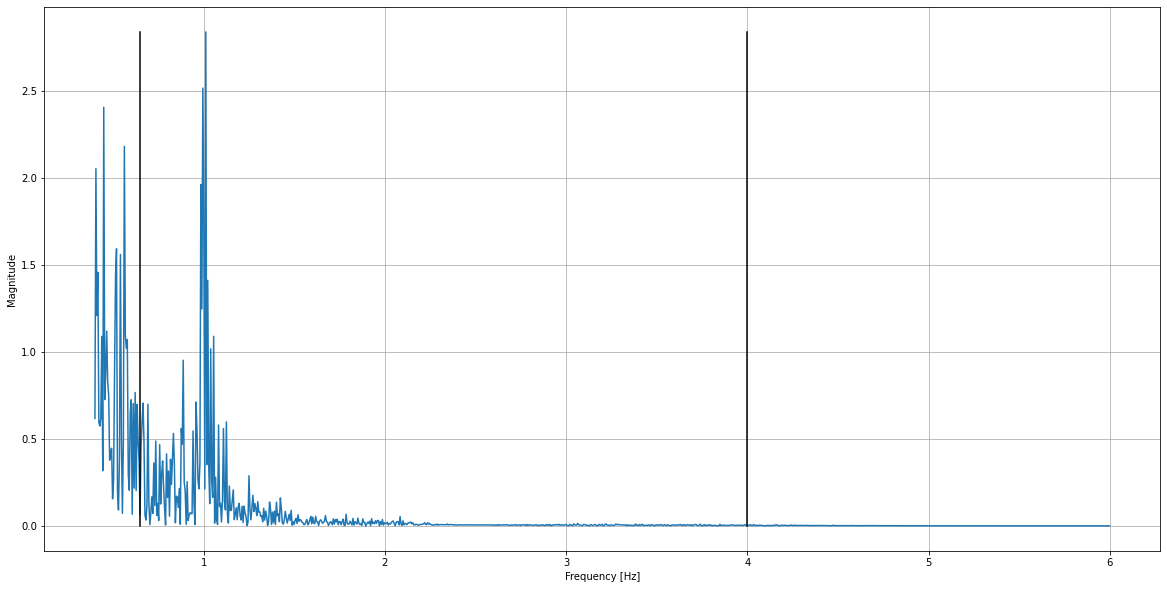

In [18]:
df_power = power_spectrum(
    signal=df_ppg['ICA_Source_0'].values,
    plot=True
)

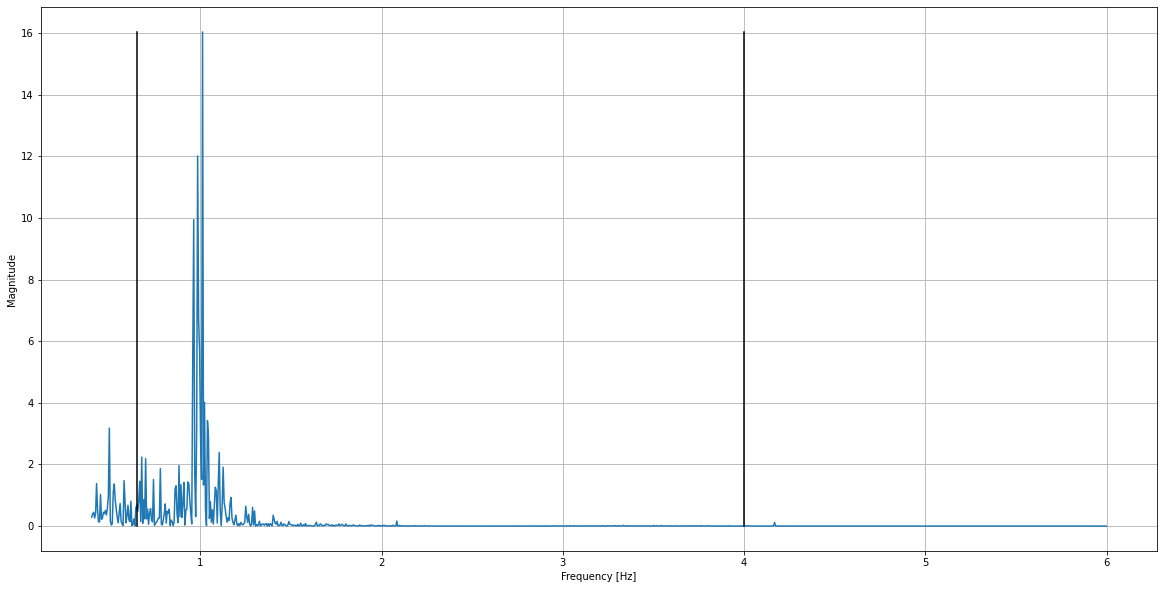

In [19]:
df_power = power_spectrum(
    signal=df_ppg['ICA_Source_1'].values,
    plot=True
)

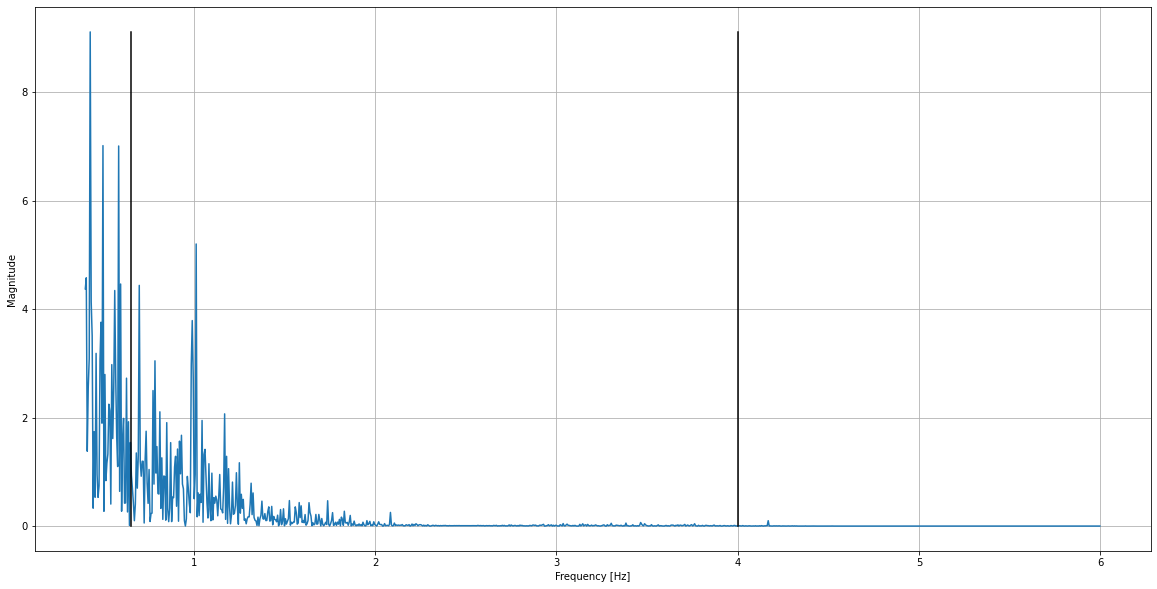

In [20]:
df_power = power_spectrum(
    signal=df_ppg['ICA_Source_2'].values,
    plot=True
)

In [22]:
df_ppg.columns

Index(['B', 'G', 'R', 'Time_ms', 'Time_s', 'B_F', 'G_F', 'R_F', 'Green_Source',
       'GRD_Source', 'ICA_Source_0', 'ICA_Source_1', 'ICA_Source_2',
       'ICA_Best_Source'],
      dtype='object')

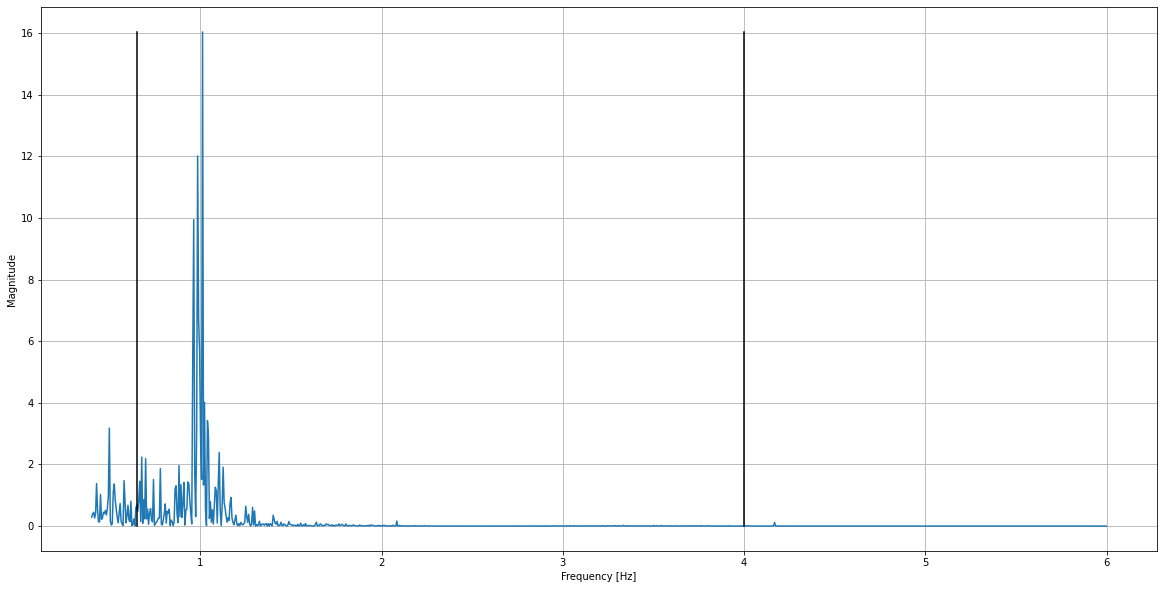

In [21]:
df_power = power_spectrum(
    signal=df_ppg['ICA_Best_Source'].values,
    plot=True
)

### Choose the PPG signal for heart beat estimation

- The signal with the heighest peak no the heart rate bandwidth (0.65-4Hz) will be the one selected

In [26]:
df_ppg.head()

B         G         R     Time_ms    Time_s       B_F       G_F  \
0  2.001988  2.287527  1.337841    0.000000  0.000000  1.557701  1.450415   
1  2.619388  2.092184  2.014784   33.333333  0.033333  1.706863  1.613131   
2  2.667611  2.081563  2.101183   66.666667  0.066667  1.848017  1.774720   
3  2.105695  2.066817  1.590124  100.000000  0.100000  1.965930  1.919052   
4  2.289754  2.001144  1.904492  133.333333  0.133333  2.039535  2.024396   

        R_F  Green_Source  GRD_Source  ICA_Source_0  ICA_Source_1  \
0  1.223815      1.450415    0.226600     -0.000704      0.010108   
1  1.354363      1.613131    0.258768     -0.000388      0.011514   
2  1.486020      1.774720    0.288699      0.000101      0.012913   
3  1.611011      1.919052    0.308041      0.000829      0.014073   
4  1.713224      2.024396    0.311172      0.001799      0.014787   

   ICA_Source_2  ICA_Best_Source  
0     -0.019715         0.010108  
1     -0.021486         0.011514  
2     -0.023154         0.012913  
3     -0.024577         0.014073  
4     -0.025510         0.014787

In [22]:
ppg_signal = select_ppg(df_ppg)

Max Peak Source:  0


In [23]:
ppg_signal

'Green_Source'

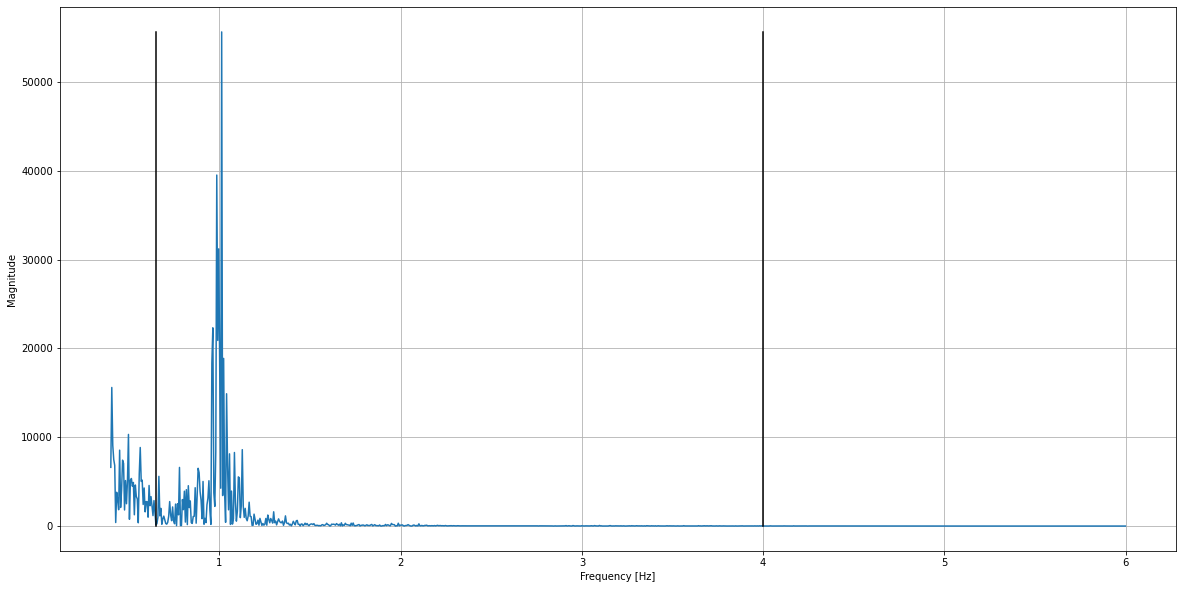

In [25]:
df_power = power_spectrum(
    signal=df_ppg['Green_Source'],
    plot=True
)

### Test Heart Rate prediction

- Using Power Spectrum

In [24]:
df_ppg.to_csv('df_ppg.csv')

In [46]:
data_path = Path("../data/")
times = {'reference':{'min':[], 'max':[]},
         'ppg':{'min':[], 'max':[]}}
for experiment in data_path.iterdir():
    reference_path = experiment / f"{experiment.stem}.csv"
    df_reference = pd.read_csv(reference_path)
    ppg_path = experiment / f"{experiment.stem}_ppg.csv"
    df_ppg = pd.read_csv(ppg_path)
    times['reference']['min'].append(df_reference['Time[ms]'].min())
    times['reference']['max'].append(df_reference['Time[ms]'].max())
    times['ppg']['min'].append(df_ppg['Time[ms]'].min())
    times['ppg']['max'].append(df_ppg['Time[ms]'].max())

    


In [51]:
np.array(times['reference']['min']) * 0.001

array([0.833, 0.833, 0.833, 0.833, 0.833, 0.833, 0.833, 0.833, 0.867,
       0.833, 1.567, 0.833, 0.833, 0.833, 0.833, 0.833, 0.833, 0.833,
       0.833])

In [52]:
np.array(times['reference']['max']) * 0.001

array([184.666, 184.5  , 188.466, 183.866, 184.366, 184.233, 184.266,
       194.433, 194.266, 189.133, 181.3  , 180.066, 179.6  , 180.9  ,
       180.766, 185.2  , 179.966, 180.166, 180.133])

In [54]:
(np.array(times['reference']['max']) * 0.001).mean()

184.2258947368421

In [55]:
np.array(times['ppg']['min']) * 0.001

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [56]:
np.array(times['ppg']['max']) * 0.001

array([185.53333333, 185.36666667, 189.33333333, 184.73333333,
       185.23333333, 185.1       , 185.13333333, 195.3       ,
       195.13333333, 190.        , 182.16666667, 180.93333333,
       180.46666667, 181.76666667, 181.63333333, 186.06666667,
       180.83333333, 181.03333333, 181.        ])

In [57]:
(np.array(times['ppg']['max']) * 0.001).mean()

185.09298245614033

Tipically we have a time range of 0.833 and 184 seconds to analyse.

In order to estimate the heart rate I decided to filter out the first and the last 10 seconds and split the remaining data into 10 different slots. This will lead to estimations of the mean heart beat during 16 seconds.

In [98]:
df_ppg.head()

Unnamed: 0         B         G         R     Time_ms    Time_s       B_F  \
0           0  2.001988  2.287527  1.337841    0.000000  0.000000  1.557701   
1           1  2.619388  2.092184  2.014784   33.333333  0.033333  1.706863   
2           2  2.667611  2.081563  2.101183   66.666667  0.066667  1.848017   
3           3  2.105695  2.066817  1.590124  100.000000  0.100000  1.965930   
4           4  2.289754  2.001144  1.904492  133.333333  0.133333  2.039535   

        G_F       R_F  Green_Source  GRD_Source  ICA_Source_0  ICA_Source_1  \
0  1.450415  1.223815      1.450415    0.226600     -0.000704      0.010108   
1  1.613131  1.354363      1.613131    0.258768     -0.000388      0.011514   
2  1.774720  1.486020      1.774720    0.288699      0.000101      0.012913   
3  1.919052  1.611011      1.919052    0.308041      0.000829      0.014073   
4  2.024396  1.713224      2.024396    0.311172      0.001799      0.014787   

   ICA_Source_2  ICA_Best_Source  Folds  
0     -0.019715         0.010108    0.0  
1     -0.021486         0.011514    0.0  
2     -0.023154         0.012913    0.0  
3     -0.024577         0.014073    0.0  
4     -0.025510         0.014787    0.0

**Instantiate a PPG object**

In [2]:
df_ppg = pd.read_csv('df_ppg.csv')

In [3]:
ppg = PPG(
    df_ppg=df_ppg, source_name='Green_Source'
)

In [5]:
ppg.ppg.head()

Unnamed: 0         B         G         R       Time_ms     Time_s  \
0         301  0.890584  1.828596  1.473081  10033.333333  10.033333   
1         302  0.938644  1.824888  1.493069  10066.666667  10.066667   
2         303  0.758906  1.931087  1.278651  10100.000000  10.100000   
3         304  1.098671  2.012907  1.716839  10133.333333  10.133333   
4         305  0.776233  2.085236  1.266731  10166.666667  10.166667   

        B_F       G_F       R_F  Green_Source  GRD_Source  ICA_Source_0  \
0  0.583821  1.809798  1.327857      1.809798    0.481941      0.021914   
1  0.587235  1.833808  1.332351      1.833808    0.501457      0.022052   
2  0.583334  1.842759  1.332607      1.842759    0.510152      0.022101   
3  0.570275  1.834936  1.330659      1.834936    0.504277      0.022088   
4  0.547342  1.811667  1.327990      1.811667    0.483677      0.022037   

   ICA_Source_1  ICA_Source_2  ICA_Best_Source  
0      0.015526      0.019889         0.015526  
1      0.016031      0.020232         0.016031  
2      0.016248      0.020489         0.016248  
3      0.016083      0.020681         0.016083  
4      0.015536      0.020855         0.015536

In [6]:
ppg.source_name

'Green_Source'

In [10]:
print(ppg)

PPG derived from Green_Source


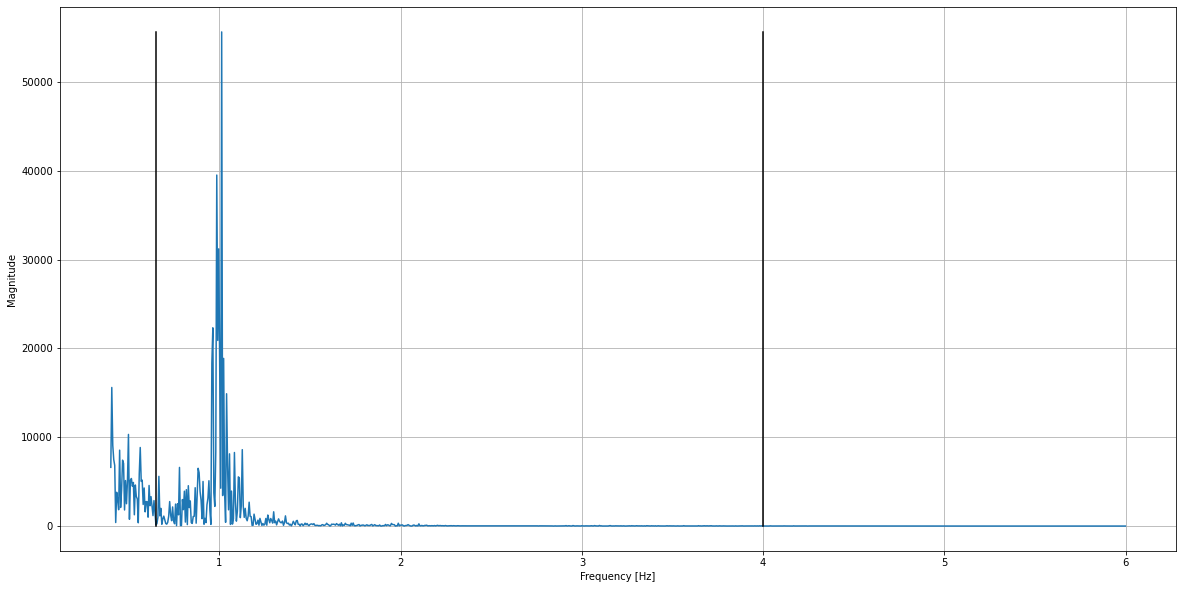

In [11]:
ppg.display_power_spectum()

In [4]:
df_raw = pd.read_csv("../data/P1LC4/P1LC4.csv")

In [6]:
df_raw_pp = ppg._process_reference(df_raw)

In [7]:
df_raw_pp.head()

Time_ms   HR[bpm]  Time_s
0    10033  69.23077  10.033
1    10067  68.85246  10.067
2    10100  68.85246  10.100
3    10133  68.85246  10.133
4    10167  68.85246  10.167

In [9]:
df_raw_pp['Time_s'].describe()

count    4919.000000
mean       92.000000
std        47.337911
min        10.033000
25%        51.016500
50%        92.000000
75%       132.983500
max       173.967000
Name: Time_s, dtype: float64

In [11]:
df_hr = ppg._estimate_heart_rate(n_folds=10)

In [14]:
df_hr

Folds    HR[Hz]    HR[bpm]
0    0.0  1.036585  62.195122
1    1.0  0.975610  58.536585
2    2.0  0.975610  58.536585
3    3.0  0.914634  54.878049
4    4.0  0.975610  58.536585
5    5.0  0.975610  58.536585
6    6.0  1.097561  65.853659
7    7.0  1.036585  62.195122
8    8.0  0.975610  58.536585
9    9.0  1.040816  62.448980

In [5]:
results = ppg.results(
    reference=df_raw,
    n_folds=10,
)

In [6]:
results

Folds    HR[Hz]    HR[bpm]  Reference[bpm]  Reference[Hz]
0    0.0  1.036585  62.195122       62.094824       1.034914
1    1.0  0.975610  58.536585       59.480328       0.991339
2    2.0  0.975610  58.536585       58.294862       0.971581
3    3.0  0.914634  54.878049       60.391408       1.006523
4    4.0  0.975610  58.536585       58.341113       0.972352
5    5.0  0.975610  58.536585       60.278874       1.004648
6    6.0  1.097561  65.853659       66.597316       1.109955
7    7.0  1.036585  62.195122       60.869100       1.014485
8    8.0  0.975610  58.536585       60.552874       1.009215
9    9.0  1.040816  62.448980       62.034048       1.033901

In [7]:
ppg.MAE(results)

1.3237784025918486

In [8]:
ppg.MSR(results)

4.097899846332856

0.784293810632895

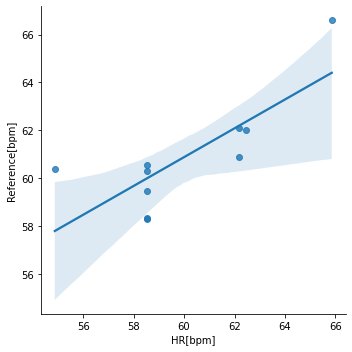

In [9]:
ppg.pearson_correlation(results, plot=True)